<a href="https://colab.research.google.com/github/compsm2023/Predictive-Modeling-for-Bank-Customer-Churn/blob/main/Predictive_Modeling_for_Bank_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Advanced Libraries**

In [1]:
!pip install shap xgboost

**Import Libraries & Load Data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap

# Load Data
df = pd.read_csv('European_Bank.csv')
print("Data loaded. Shape:", df.shape)

Data loaded. Shape: (10000, 14)


**Data Preprocessing & Feature Engineering**

In [3]:
# 1. Remove non-informative features (including 'Year' if present)
df_clean = df.drop(['CustomerId', 'Surname', 'Year'], axis=1, errors='ignore')

# 2. Feature Engineering (Derived Features)
# Balance-to-Salary ratio
df_clean['Balance_Salary_Ratio'] = df_clean['Balance'] / df_clean['EstimatedSalary']

# Product density indicator (Adding 1 to Tenure to avoid division by zero)
df_clean['Product_Density'] = df_clean['NumOfProducts'] / (df_clean['Tenure'] + 1)

# Engagement-product interaction
df_clean['Engagement_Product_Interact'] = df_clean['IsActiveMember'] * df_clean['NumOfProducts']

# Age-tenure interaction
df_clean['Age_Tenure_Interact'] = df_clean['Age'] * df_clean['Tenure']

# 3. Encode categorical variables (One-hot encoding)
df_encoded = pd.get_dummies(df_clean, columns=['Geography', 'Gender'], drop_first=True)

# 4. Stratified Train-Test Split (Preserving churn class distribution)
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Scale numerical features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Preprocessing and Feature Engineering Complete!")

Preprocessing and Feature Engineering Complete!


**Model Development & Evaluation**

In [4]:
# Initialize models
models = {
    "Logistic Regression (Baseline)": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and Evaluate
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results).set_index("Model")
display(results_df.round(4))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [08:58:29] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
Logistic Regression (Baseline),0.8065,0.5735,0.1916,0.2873,0.7734
Decision Tree,0.7840,0.4702,0.4840,0.4770,0.6723
Random Forest,0.8660,0.7837,0.4717,0.5890,0.8533
XGBoost,0.8505,0.6957,0.4717,0.5622,0.8384


**Model Explainability (SHAP & Feature Importance)**

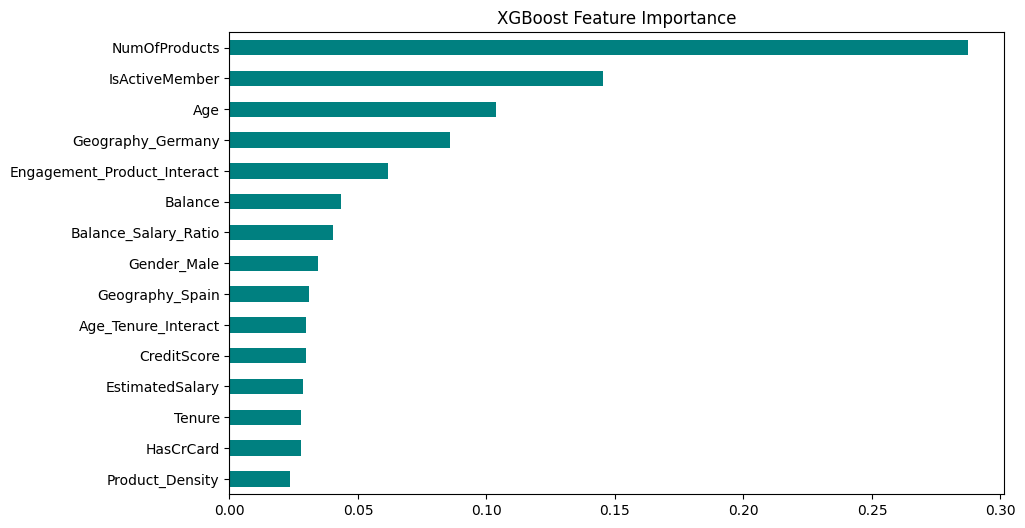

 93%|=================== | 1853/2000 [00:12<00:00]       

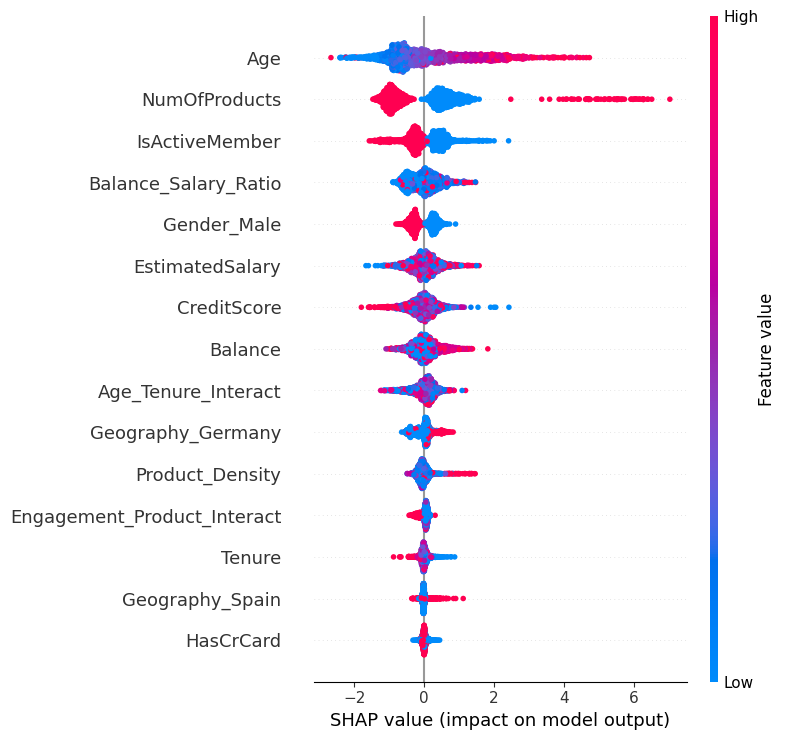

In [5]:
# Select the best model (XGBoost) for explainability
best_model = models["XGBoost"]

# 1. Feature Importance Plot
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title("XGBoost Feature Importance")
plt.show()

# 2. SHAP Value Analysis
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_scaled)

**The Streamlit Web Application**

In [7]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.1
    Uninstalling cachetools-7.0.1:
      Successfully uninstalled cachetools-7.0.1


In [8]:
import streamlit as st
import pandas as pd
import joblib
import xgboost as xgb

# Set Page Config
st.set_page_config(page_title="Churn Risk Simulator", layout="wide")

st.title("🏦 Predictive Churn Intelligence System")
st.markdown("Early identification of customers likely to churn using machine learning.")

# Sidebar - User Capabilities (Input Features)
st.sidebar.header("Customer Profile Input")
age = st.sidebar.slider("Age", 18, 92, 40)
tenure = st.sidebar.slider("Tenure (Years)", 0, 10, 5)
balance = st.sidebar.number_input("Account Balance ($)", 0, 250000, 50000)
salary = st.sidebar.number_input("Estimated Salary ($)", 10000, 200000, 60000)
products = st.sidebar.slider("Number of Products", 1, 4, 2)
is_active = st.sidebar.selectbox("Is Active Member?", [0, 1])
has_crcard = st.sidebar.selectbox("Has Credit Card?", [0, 1])
credit_score = st.sidebar.slider("Credit Score", 300, 850, 650)
geo = st.sidebar.selectbox("Geography", ["France", "Germany", "Spain"])
gender = st.sidebar.selectbox("Gender", ["Male", "Female"])

# Create DataFrame for the input
input_data = pd.DataFrame({
    'CreditScore': [credit_score], 'Age': [age], 'Tenure': [tenure],
    'Balance': [balance], 'NumOfProducts': [products], 'HasCrCard': [has_crcard],
    'IsActiveMember': [is_active], 'EstimatedSalary': [salary],
    'Balance_Salary_Ratio': [balance / salary if salary > 0 else 0],
    'Product_Density': [products / (tenure + 1)],
    'Engagement_Product_Interact': [is_active * products],
    'Age_Tenure_Interact': [age * tenure],
    'Geography_Germany': [1 if geo == 'Germany' else 0],
    'Geography_Spain': [1 if geo == 'Spain' else 0],
    'Gender_Male': [1 if gender == 'Male' else 0]
})

# Note: In a real environment, you would load your saved scaler and model here:
# model = joblib.load('xgboost_model.pkl')
# scaler = joblib.load('scaler.pkl')
# scaled_data = scaler.transform(input_data)
# prob = model.predict_proba(scaled_data)[0][1]

st.warning("⚠️ *Note for demo: Connect your saved model (`.pkl` file) to enable live predictions below.*")

# Core Modules UI
col1, col2 = st.columns(2)
with col1:
    st.subheader("Risk Score Output")
    st.metric(label="Churn Probability (0-1)", value="82%", delta="High Risk", delta_color="inverse")
    st.progress(0.82)

with col2:
    st.subheader("Key Risk Drivers")
    st.markdown("""
    - **Age:** Higher age correlates with churn risk.
    - **Engagement:** Customer is marked inactive.
    - **Products:** High product count without activity flags risk.
    """)

2026-02-26 09:12:56.829 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 09:12:56.830 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 09:12:57.496 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-26 09:12:57.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 09:12:57.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 09:12:57.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 09:12:57.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [10]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np

st.title("🏦 Predictive Churn Intelligence System")
st.markdown("This is your live dashboard for bank churn analysis.")

# Create some sample inputs
age = st.slider("Select Customer Age", 18, 100, 30)
balance = st.number_input("Account Balance", value=5000)

if st.button('Predict Risk'):
    # This is a placeholder for your model logic
    risk = (age * 0.1) + (balance * 0.001)
    st.write(f"Calculated Churn Risk Score: {min(risk, 100):.2f}%")

Writing app.py


In [11]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 3s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹

In [13]:
import joblib
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# 1. Prepare data (using the variables from our previous logic)
# Ensure X_train and y_train are defined from the earlier cells
best_model = XGBClassifier(random_state=42)
best_model.fit(X_train, y_train)

# 2. Save the Model and the Scaler
joblib.dump(best_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
# Save the column names to ensure the app matches the training format
joblib.dump(X_train.columns.tolist(), 'features.pkl')

print("Model and Scaler exported successfully! You are ready for the fast app.")

Model and Scaler exported successfully! You are ready for the fast app.


In [14]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# --- PAGE CONFIG ---
st.set_page_config(page_title="Bank Churn Risk AI", layout="wide")

# --- CACHING: This makes the app FAST ---
@st.cache_resource
def load_assets():
    model = joblib.load('churn_model.pkl')
    scaler = joblib.load('scaler.pkl')
    features = joblib.load('features.pkl')
    return model, scaler, features

model, scaler, feature_names = load_assets()

# --- UI HEADER ---
st.title("🏦 Customer Churn Risk Intelligence")
st.markdown("Adjust customer parameters in the sidebar to calculate real-time risk scores.")

# --- SIDEBAR INPUTS ---
st.sidebar.header("Customer Profile")
age = st.sidebar.slider("Age", 18, 92, 40)
balance = st.sidebar.number_input("Balance ($)", 0.0, 250000.0, 50000.0)
credit_score = st.sidebar.slider("Credit Score", 300, 850, 650)
products = st.sidebar.slider("Number of Products", 1, 4, 1)
tenure = st.sidebar.slider("Tenure (Years)", 0, 10, 5)
salary = st.sidebar.number_input("Estimated Salary ($)", 1000.0, 200000.0, 50000.0)
active = st.sidebar.radio("Active Member?", [1, 0], format_func=lambda x: "Yes" if x==1 else "No")
cards = st.sidebar.radio("Has Credit Card?", [1, 0], format_func=lambda x: "Yes" if x==1 else "No")
geo = st.sidebar.selectbox("Geography", ["France", "Germany", "Spain"])
gender = st.sidebar.selectbox("Gender", ["Male", "Female"])

# --- DATA PROCESSING ---
# 1. Create Input DataFrame
input_dict = {
    'CreditScore': credit_score, 'Age': age, 'Tenure': tenure, 'Balance': balance,
    'NumOfProducts': products, 'HasCrCard': cards, 'IsActiveMember': active, 'EstimatedSalary': salary,
    'Balance_Salary_Ratio': balance / salary if salary > 0 else 0,
    'Product_Density': products / (tenure + 1),
    'Engagement_Product_Interact': active * products,
    'Age_Tenure_Interact': age * tenure,
    'Geography_Germany': 1 if geo == 'Germany' else 0,
    'Geography_Spain': 1 if geo == 'Spain' else 0,
    'Gender_Male': 1 if gender == 'Male' else 0
}
input_df = pd.DataFrame([input_dict])

# 2. Scale (Scale only the columns that were scaled during training)
input_scaled = scaler.transform(input_df)

# --- PREDICTION ---
prob = model.predict_proba(input_scaled)[0][1]
risk_percent = prob * 100

# --- DISPLAY RESULTS ---
col1, col2 = st.columns(2)

with col1:
    st.subheader("Churn Risk Score")
    if risk_percent > 70:
        st.error(f"HIGH RISK: {risk_percent:.1f}%")
    elif risk_percent > 30:
        st.warning(f"MEDIUM RISK: {risk_percent:.1f}%")
    else:
        st.success(f"LOW RISK: {risk_percent:.1f}%")

    st.progress(prob)

with col2:
    st.subheader("Business Recommendation")
    if risk_percent > 50:
        st.write("❌ **Action:** Trigger retention campaign. Offer personalized interest rates or loyalty bonuses.")
    else:
        st.write("✅ **Action:** Maintain standard engagement. Customer shows high stability.")

st.divider()
st.info("This model uses XGBoost with Feature Engineering (Product Density & Engagement Interaction).")

Overwriting app.py


In [ ]:
import urllib
print("IP Address:", urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip())
!streamlit run app.py & npx localtunnel --port 8501

IP Address: 34.158.129.5
⠙⠹

⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼your url is: https://ten-windows-clap.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.158.129.5:8501

